# Simple CNN for MNIST

## Imports:  


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

import tensorflow as tf

sns.set(style='white', context='notebook', palette='deep')

## Data

In [2]:
train = pd.read_csv("C:/Users/chenx/Desktop/1811_softdesign/20181125 - MNIST/train.csv")
test = pd.read_csv("C:/Users/chenx/Desktop/1811_softdesign/20181125 - MNIST/test.csv")

#### Separate training data into X,Y:  
X: Training Label  
Y: Image Data

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

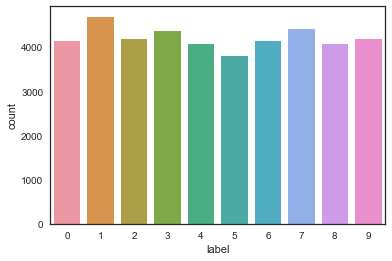

In [3]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1) 

# Visualization:
g = sns.countplot(Y_train)
Y_train.value_counts()

#### Checking for nulls:

In [4]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

#### Normalization:
  
From grayscale 0~255 to 0~1  
  

In [6]:
X_train = X_train / 255.0
test = test / 255.0

#### Reshaping:
From 1D 784 to 28x28x1

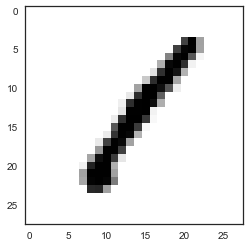

In [7]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

g = plt.imshow(X_train[0][:,:,0], cmap=plt.cm.binary)

#### Y_train label to hot vector

In [8]:
Y_train = to_categorical(Y_train, num_classes = 10)

Y_train[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

#### Splitting test data

In [9]:
random_seed = 0

X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train,
                                                  test_size=0.1, # 10% used for validation
                                                  random_state=random_seed)

## Models
+ Simple
+ Convoluted

### Super simple model
     Input Layer
     All connected, size 128
     All connected, size 128
     Output all connected, size 10

In [10]:
simple_model = Sequential()

simple_model.add(Flatten())
simple_model.add(Dense(128, activation="relu"))
simple_model.add(Dense(128, activation="relu"))
simple_model.add(Dense(10, activation="softmax"))

#### Training
    Using "adam" as optimizer: this is an ordinary optimizer for NNs
    "categorical_crossentropy" as loss function: this is also ordinary

In [11]:
simple_model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [12]:
simple_model.fit(X_train, Y_train, epochs=3)

Epoch 1/3
37800/37800 [==============================] - 4s 96us/step - loss: 0.2779 - acc: 0.9172
Epoch 2/3
37800/37800 [==============================] - 3s 84us/step - loss: 0.1151 - acc: 0.9645
Epoch 3/3
37800/37800 [==============================] - 3s 86us/step - loss: 0.0782 - acc: 0.9757


#### Evaluation
     Loss and accuracy is slightly lower than in training:
     Not very overfitted

In [13]:
val_loss, val_acc = simple_model.evaluate(X_test, Y_test)
print(val_loss, val_acc)

4200/4200 [==============================] - 0s 46us/step
0.11494366681158898 0.965952380952381


#### Looking at a random example

In [14]:
predictions = simple_model.predict([X_test])

4


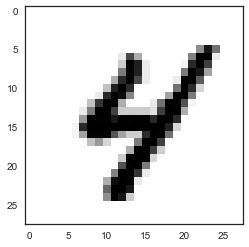

In [20]:
choice = np.random.randint(0,4201)

print(np.argmax(predictions[choice]))
g = plt.imshow(X_test[choice][:,:,0], cmap=plt.cm.binary)

#### Saving simple_model

In [18]:
simple_model.save("C:/Users/chenx/Desktop/1811_softdesign/20181125 - MNIST/simple.model")

### CNN Model:
    Convlution size32 x2
    Down Sampling by 2x2
    Drop Out by 25% probablity
    
    Convlution size64 x2
    Down Sampling by 2x2
    Drop Out by 25% probablity
    
    Flatten layer
    All connected size256
    Drop Out by 50% probablity
    Output all connected size10

In [23]:
cnn_model = Sequential()

cnn_model.add(Conv2D(filters = 32,
                    kernel_size = (5,5),
                    padding = 'Same',
                    activation = 'relu'))

cnn_model.add(Conv2D(filters = 32,
                    kernel_size = (5,5),
                    padding = 'Same',
                    activation = 'relu'))

cnn_model.add(MaxPool2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))


cnn_model.add(Conv2D(filters = 64,
                    kernel_size = (3, 3),
                    padding = 'Same',
                    activation = 'relu'))

cnn_model.add(Conv2D(filters = 64,
                    kernel_size = (3, 3),
                    padding = 'Same',
                    activation = 'relu'))

cnn_model.add(MaxPool2D(pool_size=(2, 2),
                        strides=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(0.5))
# Output Layer
cnn_model.add(Dense(10, activation='softmax'))

#### Optimizer and loss function
* Optimizer:
    RMSprop
* Loss Function:
    categorical_crossentropy as ordinary loss function

In [24]:
cnn_model.compile(optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

#### Learning rate reduction

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

#### Data augmentation
    Randomly shift, zoom ,rotate; manipulate the images to minimize overfitting

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)